# An example of using multi-imbalance
In this tutorial we will show how to increase results for multi class imbalanced datasets significantly.
The practical classification problem will serve as an example.

We will perform the processing of glass dataset.
Glass is a real-life dataset contains information about the purpose of the glass, e.g. for windows or headlights in cars.
.The purpose of glass occurs in 7 types so our problem is multi class. 
We will predict the class based on 214 examples with 9 attributes representing the content of individual elements such as Aluminum or Magnesium in the tested sample.

In [503]:
import os
import numpy as np

seed = 7
np.random.seed(seed)

%matplotlib inline

dataset_name = 'glass'
dir=os.getcwd() # te sciezkie potem poprawie, jak bedzie po releasie i w innym miejscu notebook

### Data loading

We begin with loading the data - it can be performed using the library's util for loading arff type files. The util loads arff files and performs onehotencoding for discrete variables.
The features will be ordered with all the continuous features first, followed by the ones modified by one hot encoder.

In [504]:
from multi_imbalance.utils.data import preprocess_dataset

X,y=preprocess_dataset(f'{dir}/../data/arff/{dataset_name}.arff')

print(X[:5])
print(y[:5])

[[ 1.51793 12.79     3.5      1.12    73.03     0.64     8.77     0.
   0.     ]
 [ 1.51643 12.16     3.52     1.35    72.89     0.57     8.53     0.
   0.     ]
 [ 1.51793 13.21     3.48     1.41    72.64     0.59     8.43     0.
   0.     ]
 [ 1.51299 14.4      1.74     1.54    74.55     0.       7.59     0.
   0.     ]
 [ 1.53393 12.3      0.       1.      70.16     0.12    16.19     0.
   0.24   ]]
[0 5 0 4 1]


This dataset is characterized by multi-class imbalance. In order to visualize the imbalance and difficulty of the set,
we will use the function located in multi-imbalance, which shows the class sizes and the data in a reduced two-dimensional space.

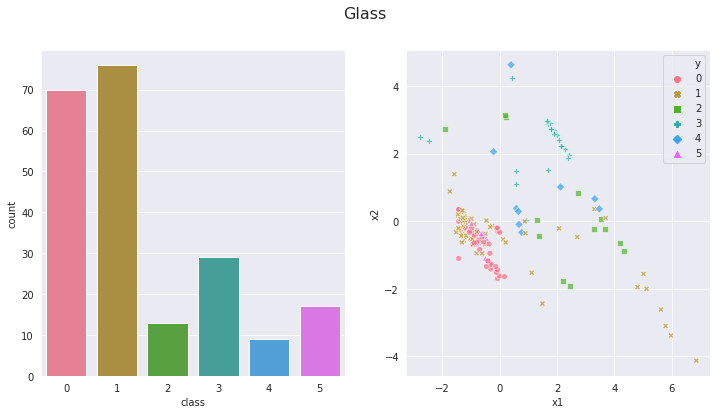

In [505]:
from multi_imbalance.utils.plot import plot_number_and_2d_data
plot_number_and_2d_data(X,y,'Glass')

As shown above, there is multi-class imbalance in the dataset. There are two majority classes and 4 minority classes. 

### Data preparation

In order to prepare data for training, we will split the data for train and test subsets and normalize it. For both operations, we will use tools available in sklearn.

In [506]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=seed)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Training

The training will be performed using a decision tree implementation from sklearn library.
Our library integrates seamlessly with other popular libraries, which enables easy use in practice and use of all the benefits of the python ecosystem.

In [507]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Due to the paradox of accuracy, which says that in the case of a large imbalance,
we can achieve great accuracy results without predicting correctly any of the minority class, we will use the g
eometric mean from the recall of each class to measure the quality of classifiers.
Where recall for a class is a percentage of how many times the predictions of the class was correct.

$$ gmean = (\Pi_{i=1}^n recall_i)^{\frac{1}{n}}$$

In [508]:
from multi_imbalance.utils.metrics import gmean_score

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.245'

As we can see, the decision tree does not perform well for this type of problem. 

### Resampling

As a solution, we propose SOUP implementation. It is a hybrid data preprocessing method, which calculates the target
class cardinality and modifies the dataset in order to match class sizes to the value previously calculated.
Additionally, a dictionary with minority classes can be passed to the method as a optional parameter.
The dictionary will be used for calculating the target cardinality.

In [509]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP()
X_train_res, y_train_res = soup.fit_transform(X_train, y_train, maj_int_min={'maj': [0, 1], 'int': [], 'min': [4, 2, 3]},)

We perform the calculations once again with modified data.

In [510]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.513'

As we can see, the preprocessing of the data improved the performance significantly. 
In the library there two types of methods implemented: preprocessing methods and ensemble methods.

### Ensemble
In this case, OVO implementation will be used. OVO is a data decomposition method, where classes are paired in all possible configurations and the paires are used to train classifiers, which vote for the final decision. OVO implementation in our libray allows the use of any type of classifier with interface compatible with sklearn convention. The same applies for resampling methods. Resampling is applied to pairs decomposed from the original data.
In this use case, SOUP will be used for resampling.

In [511]:
from multi_imbalance.ensemble.ovo import OVO

clf = OVO(
    binary_classifier=DecisionTreeClassifier(random_state=seed),
    preprocessing=SOUP()
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
gmean = gmean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.594'

As shown above, the OVO ensemble method along with SOUP resampling further improves the performance of the decision tree.

### Conclusions
In this guide we have shown that thanks to our library we can easily improve the results of prediction on difficult
real life datasets. Using only preprocessing methods we improved the result over two times and by adding the
binarization method the result changed from 0.245 up to 0.594! During the entire tutorial, we seamlessly integrated with
popular libraries like sklearn and worked using well-known types like numpy arrays.
You can find more examples and descriptions of all methods in the documentation: https://multi-imbalance.readthedocs.io/en/latest/